In [1]:
from pathlib import Path
import sys
sys.path.append("../../")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from models.vae import Base, LMCVAE
from distributions.samplers import HMC, run_chain
from distributions.distributions import Banana

import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

%matplotlib widget

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
CUDA_VISIBLE_DEVICES='1'

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
n_steps = 1
dist = "banana"
dim = 100
scale_proposal = 1.
scale_isir = 5.
dist_class = "Banana"
dist_params = {
    "b": 0.02,
    "sigma":5.0,
}
sigma = 5
b = 0.02

In [7]:

target = Banana(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,
                #b = b
                #**dist_params.dict,
)

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)



In [8]:
class Banana_Dataset(Dataset):
    def __init__(self, data):
        super(Banana_Dataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = torch.tensor(self.data[item], dtype=torch.float32, device=device)
        return sample, -1.

## Model

In [9]:
latent_dim = 2*dim


class BananaEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(dim, 2*dim),
            nn.ReLU(),
            nn.Linear(2*dim, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

    
class BananaDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim // 2, 2*dim),
            nn.ReLU(),
            nn.Linear(2*dim, dim),
        )

    def forward(self, x):
        return self.net(x)
    

class TrueDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = b
        self.sigma = sigma

    def forward(self, z):
        for i in range(z.size(1)):
            if i % 2 == 0:
                z[:,i] *= sigma
            else:
                z[:,i] += b*z[:,i-1]**2 - (sigma**2)*b
        return z

In [10]:
def generate_dataset(N_samples, dim, sigma = 1.0):
    np.random.seed(42)
    True_samples = np.random.randn(N_samples, dim)
    for i in range(dim):
        if i % 2 == 0:
            True_samples[:,i] *= sigma
        else:
            True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b
    return True_samples



class Toy(Base):   
    def joint_logdensity(self, use_true_decoder=None):
        def density(z, x):
            if (use_true_decoder is not None) and use_true_decoder:
                x_reconst = self(z)
            elif hasattr(self, 'use_cloned_decoder') and self.use_cloned_decoder:
                x_reconst = self.cloned_decoder(z)
            else:
                x_reconst = self(z)
            log_Pr = torch.distributions.Normal(loc=torch.tensor(0., device=x.device, dtype=torch.float32),
                                    scale=torch.tensor(1., device=x.device, dtype=torch.float32)).log_prob(
                    z).sum(-1)
            
            even = np.arange(0, dim, 2)
            odd = np.arange(1, dim, 2)

            z_new = torch.zeros(z.size()).to(device)
            z_new[..., even] = z[..., even] * sigma
            z_new[..., odd] = z[..., odd] + b * z[..., even] ** 2 - (sigma**2) * b

            
            likelihood = torch.distributions.Normal(loc=z_new,
                                                    scale=0.3 * torch.ones_like(x_reconst)).log_prob(
                x.view(*x_reconst.shape)).sum(-1)
            
            return  likelihood
        return density
    
    
    
class LMCVAE_Toy(LMCVAE, Toy):
    def loss_function(self, sum_log_weights):
        loss = super(LMCVAE_Toy, self).loss_function(sum_log_weights)
        return loss

        

In [11]:
N = 10000
d = dim
b = 0.02
eps = 2 + np.random.randn(1, d)
X_train = generate_dataset(N_samples=N, dim=d, sigma=sigma)
X_val = generate_dataset(N_samples=N // 100, dim=d, sigma=sigma)
train_dataset = Banana_Dataset(data= X_train)
val_dataset = Banana_Dataset(data=X_val)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [12]:
banana_enc = BananaEncoder().to(device)

In [13]:
def replace_enc_dec(model):
    model.encoder_net = BananaEncoder().to(device)
    model.decoder_net = BananaDecoder().to(device)
    model = model.to(device)
    return model

In [14]:
seed_everything(42)
lmcvae = LMCVAE_Toy(shape=2, act_func=nn.LeakyReLU,
                    num_samples=1, hidden_dim=d,
                    net_type='conv', dataset='toy',
                    step_size=0.01, K=5, use_transforms=False, learnable_transitions=False, return_pre_alphas=True, use_score_matching=False,
                    ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=True,
                    acceptance_rate_target=0.9, annealing_scheme='all_learnable')
lmcvae = replace_enc_dec(lmcvae)
lmcvae.name = 'LMCVAE'

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [15]:
def run_trainer(model):
    seed_everything(42)
    tb_logger = pl_loggers.TensorBoardLogger('lightning_logs/')
    trainer = pl.Trainer(logger=tb_logger, fast_dev_run=False, max_epochs=31) #automatic_optimization=True
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [16]:
run_trainer(lmcvae)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/lightning_logs

  | Name            | Type          | Params
--------------------------------------------------
0 | encoder_net     | BananaEncoder | 60.4 K
1 | decoder_net     | BananaDecoder | 40.3 K
2 | transitions_nll | ModuleList    | 8     
3 | transitions     | ModuleList    | 5     
--------------------------------------------------
100 K     Trainable params
13        Non-trainable params
100 K     Total params
0.403     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=31` reached.


In [18]:
n_leapfrogs = 5
step_size = 0.01
n_samples = 6000
hmc = HMC(n_leapfrogs=n_leapfrogs, step_size=step_size, partial_ref=False, use_barker=False).to(device)


True_post_samples = np.random.randn(n_samples,dim)
for i in range(dim):
    if i % 2 == 0:
      True_post_samples[:,i] *= sigma
    else:
      True_post_samples[:,i] += b*True_post_samples[:,i-1]**2 - (sigma**2)*b

X_item = torch.tensor(True_post_samples, device=device, dtype=torch.float32)

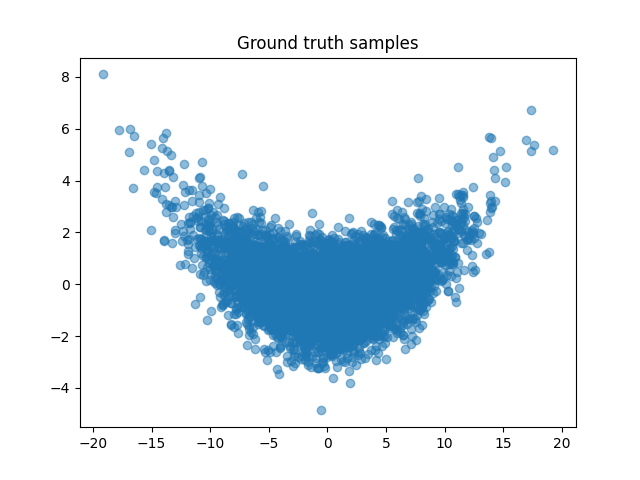

In [19]:
fig,ax=plt.subplots(1,1)
X_ = X_item.to('cpu')
ax.scatter(X_[:,0],X_[:,1], alpha=0.5)
ax.set_title('Ground truth samples')
plt.show()

In [20]:
## Receive true posterior sample:
def target_density(z, x):
    even = np.arange(0, dim, 2)
    odd = np.arange(1, dim, 2)


    z_new = torch.zeros(z.size()).to(device)
    z_new[..., even] = z[..., even] * sigma
    z_new[..., odd] = z[..., odd] + b * z[..., even] ** 2 - (sigma**2) * b


    ll = torch.distributions.Normal(loc=z_new, scale=0.3).log_prob(X_item).sum(-1)
    
    return ll 



true_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, dim, device=device), target=target_density, return_trace=False,
                                   n_steps=1, burnin=500).cpu().numpy()

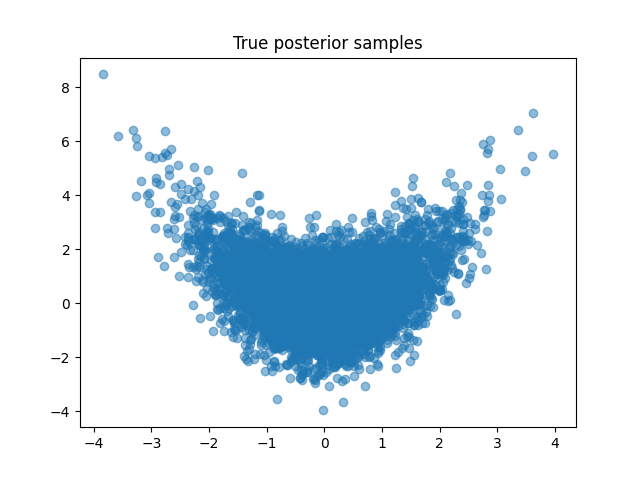

In [21]:
fig,ax=plt.subplots(1,1)
ax.scatter(true_posterior_samples[:,0],true_posterior_samples[:,1], alpha=0.5)
ax.set_title('True posterior samples')
plt.show()

In [24]:
def receive_model_samples(model, X_item, stacked=False):
    with torch.no_grad():
        x = X_item
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=1)
        if model.name in ['LMCVAE', 'AMCVAE']:
            model_samples_init = model_samples
            model_samples = model.run_transitions(z=model_samples, x=x, mu=mu, logvar=logvar)[0]
    return model_samples.cpu().numpy()

def plot_contours(model, X_item, stacked=False, graph=None):
    x = X_item
    with torch.no_grad():
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        logprobs = torch.distributions.Normal(loc=mu, scale=torch.exp(0.5 * logvar)).log_prob(model_samples).sum(-1)
    if graph is None:
        plt.scatter(model_samples[:, 0].cpu(), model_samples[:, 1].cpu(),)
    else:
        graph.x = model_samples[:, 0].cpu()
        graph.y = model_samples[:, 1].cpu()
        graph.plot_joint(plt.scatter, marker='x', c='g', s=50, alpha=0.5)
    

def receive_posterior_samples(model, n_samples, stacked=False):
    with torch.no_grad():
        model_target_density = lambda z, x: model.joint_logdensity()(z=z, x=X_item)
        model_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, dim, device=device), target=model_target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()
    return model_posterior_samples

In [25]:
lmcvae_sample = receive_model_samples(lmcvae, X_item)
lmcvae_posterior_sample = receive_posterior_samples(lmcvae, n_samples)

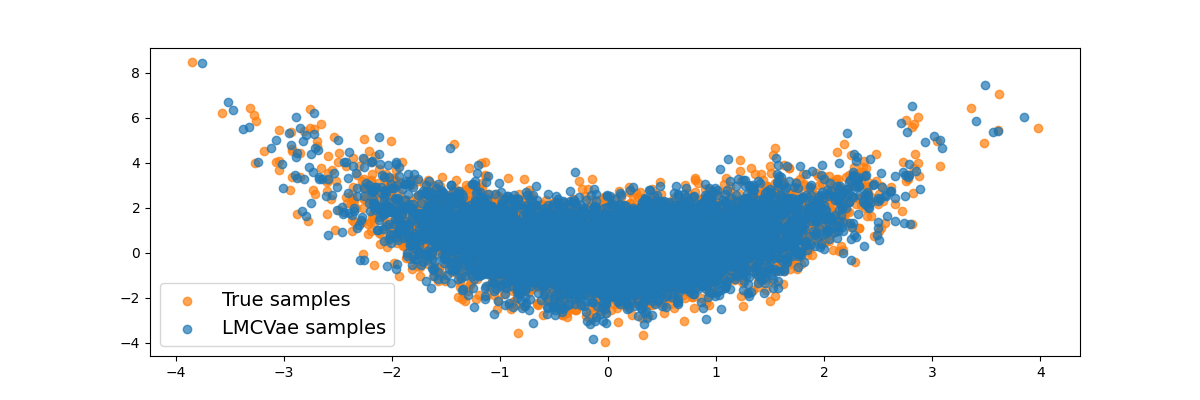

In [26]:
fig, axs = plt.subplots(1,1,figsize=(12,4))
axs.scatter(true_posterior_samples[:,0],true_posterior_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
axs.scatter(lmcvae_posterior_sample[:, 0] ,lmcvae_posterior_sample[:, 1],c='#1f77b4', alpha = 0.7, label = "LMCVae samples")


ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.legend(fontsize=14)

plt.show()